In [1]:
# Install necessary libraries
!pip install torch torchvision torchaudio
!pip install torch-geometric
!pip install tikzplotlib
!pip install grape
!pip install seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 832.3 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.2/54.2 kB 1.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 252.8/252.8 kB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.7/323.7 kB 10.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (set

In [2]:
!nvidia-smi

Fri Sep 20 23:42:36 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
# basics
import numpy as np
import pandas as pd
import tensorflow as tf

# math
from math import ceil
from math import log
from math import log10

# utils
import itertools as it
import time
#from varname import nameof # get the name of a variable
import pickle
from tqdm.auto import tqdm, trange
#from tqdm import tqdm  RuntimeError: CUDA error: device-side assert triggered
import inspect
from grape.datasets.linqs import get_words_data # words information is excluded
import glob


# plot
import matplotlib as mpl
import matplotlib.pyplot as plt
import tikzplotlib
#from barplots import barplots
import matplotlib.colors as colors
import seaborn as sns

# torch geometrics

import torch
import torch.optim as optim

from torch_geometric.datasets import FB15k_237
from torch_geometric.nn import ComplEx, DistMult, RotatE, TransE
from torch_geometric.data import Data

import os.path as osp

# Convolutional GNN

import torch_geometric.transforms as T

from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv
from torch_geometric.utils import negative_sampling
from torch_geometric.loader import LinkNeighborLoader

from torch_geometric.nn import RGCNConv

from sklearn.metrics import roc_auc_score

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [5]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [6]:
# Load graph
view=1
view_name='VIEW'+str(view)
results = pd.DataFrame()

# Load graph
view_path='/content/drive/MyDrive/VIEW'+str(view)+"/"

nodes_df = pd.read_pickle(view_path+"nodes.pkl")
edges_df = pd.read_pickle(view_path+"edges.pkl")

In [7]:
# TRAIN DATASET

nodes_df.to_csv(view_path+"nodes.csv", header=False, index=False, sep='\t')
edges_df.to_csv(view_path+"edges.csv", header=False, index=False, sep='\t')

In [8]:
# One-hot encoding of the types
class TypeOneHotEncoder:
    def __init__(self, sep='|'):
        self.sep = sep

    def __call__(self, df):
        types = set(g for col in df.values for g in col.split(self.sep))
        mapping = {type: i for i, type in enumerate(types)}

        x = torch.zeros(len(df), len(mapping))
        for i, col in enumerate(df.values):
            for type in col.split(self.sep):
                x[i, mapping[type]] = 1
        return x

# Integer encoding for types
class TypeIntegerEncoder:
    def __init__(self, sep='|'):
        self.sep = sep

    def __call__(self, df):
        types = set(g for col in df.values for g in col.split(self.sep))
        mapping = {type: i for i, type in enumerate(types)}

        x = torch.zeros(len(df), 1)
        for i, type in enumerate(df.values):
                x[i] = mapping[type]
        return x.to(torch.float)

In [9]:
def load_node_df(df, index_col, encoders=None, **kwargs):

    # Integer encoding for the types
    type_mapping: Dict[str, int] = {}

    df = df.set_index(index_col)
    # Create te mapping for the index
    mapping = {index: i for i, index in enumerate(df.index.unique())}

    # Create the features for the nodes
    x = None
    if encoders is not None:
        xs = [encoder(df[col]) for col, encoder in encoders.items()]
        x = torch.cat(xs, dim=-1)

    return x, mapping

def load_edge_df(df, src_index_col, src_mapping, dst_index_col, dst_mapping,
                 pred_index_col=None, pred_mapping=None, encoders=None, **kwargs):

    src = [src_mapping[index] for index in df[src_index_col]]
    dst = [dst_mapping[index] for index in df[dst_index_col]]
    edge_index = torch.tensor([src, dst])

    # Edge Types
    edge_attr = None
    # Edge mapping
    if pred_mapping is not None:
        edge_attrs = torch.zeros(len(df), 1)
        for i, type in enumerate(df[pred_index_col].values):
            edge_attrs[i] = pred_mapping[type]
        edge_attr = edge_attrs.to(torch.int64)
    # No mapping but encoder
    if encoders is not None:
        edge_attrs = [encoder(df[col]) for col, encoder in encoders.items()]
        edge_attr = torch.cat(edge_attrs, dim=-1)

    return edge_index, edge_attr

In [10]:
# Train

nodes_x, node_mapping = load_node_df(nodes_df, index_col='name',
                                     encoders={'type': TypeIntegerEncoder()}
                                    )

# Edge type mapping (same for train/test)
pred_mapping = {index: i for i, index in enumerate(edges_df.predicate.unique())}

edge_index, edge_type = load_edge_df(
    edges_df,
    src_index_col='subject', src_mapping = node_mapping,
    dst_index_col='object', dst_mapping = node_mapping,
    pred_index_col='predicate', pred_mapping = pred_mapping,
     # encoders={
     #     'predicate': TypeIntegerEncoder()
     #     }
    )

In [11]:
data = Data(x=nodes_x, edge_index=edge_index, edge_type=edge_type)

# For this, we first split the set of edges into
# training (80%), validation (10%), and testing edges (10%).
# Across the training edges, we use 70% of edges for message passing,
# and 30% of edges for supervision.
# We further want to generate fixed negative edges for evaluation with a ratio of 2:1.
# Negative edges during training will be generated on-the-fly, so we don't want to
# add them to the graph right away.
# Overall, we can leverage the `RandomLinkSplit()` transform for this from PyG:
from torch_geometric.transforms import RandomLinkSplit
transform = RandomLinkSplit()

train_data, val_data, test_data = transform(data)

train_data = train_data.to(device)
val_data = val_data.to(device)
test_data = test_data.to(device)

In [12]:
print(f"Edges Train: {len(train_data.edge_label_index[0])}  Test:{len(test_data.edge_label_index[0])}  Validation: {len(val_data.edge_label_index[0])}")

Edges Train: 2365462  Test:675846  Validation: 337922


In [13]:
## EXTERNAL TEST SETS

## VIEW 0-2
test_sets = ['miRNA-disease2bepred']
test_df = pd.read_csv(view_path+test_sets[0]+".txt", sep='\t')

## VIEW 3-5
#test_df = pd.read_csv(view_path+"miRNA-disease2bepred.txt", sep='\t')
#test_sets = ['miRNA-disease2bepred']
#test_sets = ['SPIRES_FN','SPIRES_FP','SPIRES_TP']

## VIEW 6-8
#test_df = pd.read_csv(view_path+"miRNA-gene2bepred.csv", sep='\t')
#test_sets = ['SPIRES_FN','SPIRES_FP','SPIRES_TP']

## VIEW 12-15 NO HEADERS!!
#test_df = pd.read_csv(view_path+"test.txt",names=["subject","predicate","object"], sep='\t')

In [14]:
# Remove edges with unknown nodes
sources_in_graph = test_df.subject.apply(lambda x: x in nodes_df.name.values)
destinations_in_graph = test_df.object.apply(lambda x: x in nodes_df.name.values)

edge_extremes_in_graph = [a and b for a, b in zip(sources_in_graph, destinations_in_graph)]

print([[x,edge_extremes_in_graph.count(x)] for x in set(edge_extremes_in_graph)])

edges_to_predict_filtered = test_df[edge_extremes_in_graph]

test_edge_index, test_edge_type = load_edge_df(
    edges_to_predict_filtered,
    src_index_col='subject', src_mapping = node_mapping,
    dst_index_col='object', dst_mapping = node_mapping,
    pred_index_col='predicate', pred_mapping = pred_mapping,
     # encoders={
     #     'predicate': TypeIntegerEncoder()
     #     }
    )

external_test_data = Data(x=nodes_x,
                 edge_index=test_edge_index,
                 edge_type=test_edge_type,
                 edge_label_index=test_edge_index,
                 edge_label=torch.ones(test_edge_index.size(1))
                ).to(device)

[[False, 12], [True, 16900]]


In [15]:
class Net(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_relations):
        super().__init__()
        self.conv1 = RGCNConv(in_channels, hidden_channels, num_relations)
        self.conv2 = RGCNConv(hidden_channels, out_channels, num_relations)

    def encode(self, x, edge_index, edge_type):
        edge_type = edge_type.view(-1)
        x = self.conv1(x, edge_index, edge_type).relu()
        return self.conv2(x, edge_index, edge_type)

    def decode(self, z, edge_label_index):
        return (z[edge_label_index[0]] * z[edge_label_index[1]]).sum(dim=-1)

    def decode_all(self, z):
        prob_adj = z @ z.t()
        return (prob_adj > 0).nonzero(as_tuple=False).t()

In [16]:
num_relations = len(pred_mapping)
model = Net(train_data.num_features, 32, 64, num_relations).to(device)
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)
criterion = torch.nn.BCEWithLogitsLoss()

In [17]:
def train():
    model.train()
    optimizer.zero_grad()

    # Flatten edge_type to make sure it's 1D
    edge_type = train_data.edge_type.view(-1)  # Ensure it's 1D

    z = model.encode(train_data.x, train_data.edge_index, edge_type)

    # We perform a new round of negative sampling for every training epoch:
    neg_edge_index = negative_sampling(
        edge_index=train_data.edge_index, num_nodes=train_data.num_nodes,
        num_neg_samples=train_data.edge_label_index.size(1), method='sparse')

    edge_label_index = torch.cat(
        [train_data.edge_label_index, neg_edge_index],
        dim=-1,
    )

    edge_label = torch.cat([
        train_data.edge_label,
        train_data.edge_label.new_zeros(neg_edge_index.size(1))
    ], dim=0)

    out = model.decode(z, edge_label_index).view(-1)
    loss = criterion(out, edge_label)
    loss.backward()
    optimizer.step()
    return loss.item()


In [18]:
@torch.no_grad()
def test(data):
    model.eval()
    edge_type = data.edge_type.view(-1)  # Ensure edge_type is 1D

    z = model.encode(data.x, data.edge_index, edge_type)

    out = model.decode(z, data.edge_label_index).view(-1).sigmoid()
    return roc_auc_score(data.edge_label.cpu().numpy(), out.cpu().numpy())


In [19]:
@torch.no_grad()
def get_prob(data):
    model.eval()
    z = model.encode(data.x, data.edge_index, data.edge_type)
    out = model.decode(z, data.edge_label_index).view(-1).sigmoid()
    return out.cpu().numpy()

@torch.no_grad()
def get_emb(data):
    model.eval()

    # Ensure edge_type is 1D
    edge_type = data.edge_type.view(-1)  # Flatten edge_type to be 1D if necessary

    # Check edge_index dimensions
    if data.edge_index.dim() != 2 or data.edge_index.size(0) != 2:
        raise ValueError(f"Expected edge_index with shape [2, num_edges], but got {data.edge_index.shape}")

    z = model.encode(data.x, data.edge_index, data.edge_type)
    return z.cpu().numpy()

best_val_auc = final_test_auc = 0

In [ ]:
# Training
n_epochs=25

for epoch in range(1, n_epochs):
    loss = train()
    #val_auc = test(val_data)
    #test_auc = test(test_data)
    #if val_auc > best_val_auc:
    #    best_val_auc = val_auc
    #    final_test_auc = test_auc
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}'
    #, Val: {val_auc:.4f}' #'f'Test: {test_auc:.4f}'
         )

Epoch: 001, Loss: 193.5661
Epoch: 002, Loss: 102.2624
Epoch: 003, Loss: 56.2036
Epoch: 004, Loss: 36.6110
Epoch: 005, Loss: 29.9147
Epoch: 006, Loss: 27.7511
Epoch: 007, Loss: 26.0913
Epoch: 008, Loss: 23.3800
Epoch: 009, Loss: 20.0880
Epoch: 010, Loss: 17.2885
Epoch: 011, Loss: 14.5004
Epoch: 012, Loss: 12.0988
Epoch: 013, Loss: 10.3637
Epoch: 014, Loss: 9.0062
Epoch: 015, Loss: 7.7896
Epoch: 016, Loss: 6.7612
Epoch: 017, Loss: 5.9355
Epoch: 018, Loss: 5.2349
Epoch: 019, Loss: 4.7039
Epoch: 020, Loss: 4.3411
Epoch: 021, Loss: 4.0110
Epoch: 022, Loss: 3.7368
Epoch: 023, Loss: 3.5440
Epoch: 024, Loss: 3.3895


In [ ]:
# Training
n_epochs=50

for epoch in range(1, n_epochs):
    loss = train()
    #val_auc = test(val_data)
    #test_auc = test(test_data)
    #if val_auc > best_val_auc:
    #    best_val_auc = val_auc
    #    final_test_auc = test_auc
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}'
    #, Val: {val_auc:.4f}' #'f'Test: {test_auc:.4f}'
         )

Epoch: 001, Loss: 3.2470
Epoch: 002, Loss: 3.0923
Epoch: 003, Loss: 2.9319
Epoch: 004, Loss: 2.7485
Epoch: 005, Loss: 2.5734
Epoch: 006, Loss: 2.4409
Epoch: 007, Loss: 2.2818
Epoch: 008, Loss: 2.1520
Epoch: 009, Loss: 2.0266
Epoch: 010, Loss: 1.9182
Epoch: 011, Loss: 1.8243
Epoch: 012, Loss: 1.7377
Epoch: 013, Loss: 1.6661
Epoch: 014, Loss: 1.5954
Epoch: 015, Loss: 1.5320
Epoch: 016, Loss: 1.4731
Epoch: 017, Loss: 1.4191
Epoch: 018, Loss: 1.3714
Epoch: 019, Loss: 1.3238
Epoch: 020, Loss: 1.2863
Epoch: 021, Loss: 1.2498
Epoch: 022, Loss: 1.2146
Epoch: 023, Loss: 1.1874
Epoch: 024, Loss: 1.1632
Epoch: 025, Loss: 1.1394
Epoch: 026, Loss: 1.1216
Epoch: 027, Loss: 1.0989
Epoch: 028, Loss: 1.0812
Epoch: 029, Loss: 1.0651
Epoch: 030, Loss: 1.0483
Epoch: 031, Loss: 1.0322
Epoch: 032, Loss: 1.0185
Epoch: 033, Loss: 1.0033
Epoch: 034, Loss: 0.9887
Epoch: 035, Loss: 0.9781
Epoch: 036, Loss: 0.9625
Epoch: 037, Loss: 0.9539
Epoch: 038, Loss: 0.9404
Epoch: 039, Loss: 0.9287
Epoch: 040, Loss: 0.9181


In [ ]:
# Training
n_epochs=25

for epoch in range(1, n_epochs):
    loss = train()
    #val_auc = test(val_data)
    #test_auc = test(test_data)
    #if val_auc > best_val_auc:
    #    best_val_auc = val_auc
    #    final_test_auc = test_auc
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}'
    #, Val: {val_auc:.4f}' #'f'Test: {test_auc:.4f}'
         )

Epoch: 001, Loss: 0.8407
Epoch: 002, Loss: 0.8351
Epoch: 003, Loss: 0.8287
Epoch: 004, Loss: 0.8240
Epoch: 005, Loss: 0.8213
Epoch: 006, Loss: 0.8147
Epoch: 007, Loss: 0.8093
Epoch: 008, Loss: 0.8048
Epoch: 009, Loss: 0.8014
Epoch: 010, Loss: 0.7955
Epoch: 011, Loss: 0.7922
Epoch: 012, Loss: 0.7905
Epoch: 013, Loss: 0.7885
Epoch: 014, Loss: 0.7811
Epoch: 015, Loss: 0.7794
Epoch: 016, Loss: 0.7779
Epoch: 017, Loss: 0.7731
Epoch: 018, Loss: 0.7703
Epoch: 019, Loss: 0.7681
Epoch: 020, Loss: 0.7650
Epoch: 021, Loss: 0.7608
Epoch: 022, Loss: 0.7586
Epoch: 023, Loss: 0.7557
Epoch: 024, Loss: 0.7538


In [ ]:
# Training
n_epochs=50

for epoch in range(1, n_epochs):
    loss = train()
    #val_auc = test(val_data)
    #test_auc = test(test_data)
    #if val_auc > best_val_auc:
    #    best_val_auc = val_auc
    #    final_test_auc = test_auc
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}'
    #, Val: {val_auc:.4f}' #'f'Test: {test_auc:.4f}'
         )

Epoch: 001, Loss: 0.7516
Epoch: 002, Loss: 0.7480
Epoch: 003, Loss: 0.7487
Epoch: 004, Loss: 0.7440
Epoch: 005, Loss: 0.7418
Epoch: 006, Loss: 0.7414
Epoch: 007, Loss: 0.7388
Epoch: 008, Loss: 0.7365
Epoch: 009, Loss: 0.7348
Epoch: 010, Loss: 0.7309
Epoch: 011, Loss: 0.7292
Epoch: 012, Loss: 0.7288
Epoch: 013, Loss: 0.7269
Epoch: 014, Loss: 0.7255
Epoch: 015, Loss: 0.7228
Epoch: 016, Loss: 0.7213
Epoch: 017, Loss: 0.7187
Epoch: 018, Loss: 0.7173
Epoch: 019, Loss: 0.7156
Epoch: 020, Loss: 0.7151
Epoch: 021, Loss: 0.7138
Epoch: 022, Loss: 0.7121
Epoch: 023, Loss: 0.7101
Epoch: 024, Loss: 0.7088
Epoch: 025, Loss: 0.7073
Epoch: 026, Loss: 0.7059
Epoch: 027, Loss: 0.7060
Epoch: 028, Loss: 0.7034
Epoch: 029, Loss: 0.7021
Epoch: 030, Loss: 0.7009
Epoch: 031, Loss: 0.6979
Epoch: 032, Loss: 0.6983
Epoch: 033, Loss: 0.6971
Epoch: 034, Loss: 0.6957
Epoch: 035, Loss: 0.6949
Epoch: 036, Loss: 0.6940
Epoch: 037, Loss: 0.6923
Epoch: 038, Loss: 0.6914
Epoch: 039, Loss: 0.6896
Epoch: 040, Loss: 0.6900


In [ ]:
# Training
n_epochs=50

for epoch in range(1, n_epochs):
    loss = train()
    #val_auc = test(val_data)
    #test_auc = test(test_data)
    #if val_auc > best_val_auc:
    #    best_val_auc = val_auc
    #    final_test_auc = test_auc
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}'
    #, Val: {val_auc:.4f}' #'f'Test: {test_auc:.4f}'
         )

Epoch: 001, Loss: 0.6809
Epoch: 002, Loss: 0.6794
Epoch: 003, Loss: 0.6786
Epoch: 004, Loss: 0.6783
Epoch: 005, Loss: 0.6770
Epoch: 006, Loss: 0.6760
Epoch: 007, Loss: 0.6749
Epoch: 008, Loss: 0.6746
Epoch: 009, Loss: 0.6734
Epoch: 010, Loss: 0.6729
Epoch: 011, Loss: 0.6726
Epoch: 012, Loss: 0.6717
Epoch: 013, Loss: 0.6713
Epoch: 014, Loss: 0.6703
Epoch: 015, Loss: 0.6699
Epoch: 016, Loss: 0.6689
Epoch: 017, Loss: 0.6682
Epoch: 018, Loss: 0.6674
Epoch: 019, Loss: 0.6674
Epoch: 020, Loss: 0.6662
Epoch: 021, Loss: 0.6657
Epoch: 022, Loss: 0.6651
Epoch: 023, Loss: 0.6650
Epoch: 024, Loss: 0.6636
Epoch: 025, Loss: 0.6624
Epoch: 026, Loss: 0.6630
Epoch: 027, Loss: 0.6620
Epoch: 028, Loss: 0.6620
Epoch: 029, Loss: 0.6607
Epoch: 030, Loss: 0.6601
Epoch: 031, Loss: 0.6599
Epoch: 032, Loss: 0.6593
Epoch: 033, Loss: 0.6593
Epoch: 034, Loss: 0.6584
Epoch: 035, Loss: 0.6581
Epoch: 036, Loss: 0.6579
Epoch: 037, Loss: 0.6566
Epoch: 038, Loss: 0.6570
Epoch: 039, Loss: 0.6561
Epoch: 040, Loss: 0.6552


In [ ]:
# Training
n_epochs=50

for epoch in range(1, n_epochs):
    loss = train()
    #val_auc = test(val_data)
    #test_auc = test(test_data)
    #if val_auc > best_val_auc:
    #    best_val_auc = val_auc
    #    final_test_auc = test_auc
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}'
    #, Val: {val_auc:.4f}' #'f'Test: {test_auc:.4f}'
         )

Epoch: 001, Loss: 0.6504
Epoch: 002, Loss: 0.6501
Epoch: 003, Loss: 0.6509
Epoch: 004, Loss: 0.6499
Epoch: 005, Loss: 0.6495
Epoch: 006, Loss: 0.6491
Epoch: 007, Loss: 0.6488
Epoch: 008, Loss: 0.6482
Epoch: 009, Loss: 0.6470
Epoch: 010, Loss: 0.6477
Epoch: 011, Loss: 0.6480
Epoch: 012, Loss: 0.6472
Epoch: 013, Loss: 0.6466
Epoch: 014, Loss: 0.6459
Epoch: 015, Loss: 0.6456
Epoch: 016, Loss: 0.6457
Epoch: 017, Loss: 0.6443
Epoch: 018, Loss: 0.6448
Epoch: 019, Loss: 0.6439
Epoch: 020, Loss: 0.6441
Epoch: 021, Loss: 0.6436
Epoch: 022, Loss: 0.6434
Epoch: 023, Loss: 0.6430
Epoch: 024, Loss: 0.6429
Epoch: 025, Loss: 0.6424
Epoch: 026, Loss: 0.6421
Epoch: 027, Loss: 0.6412
Epoch: 028, Loss: 0.6416
Epoch: 029, Loss: 0.6408
Epoch: 030, Loss: 0.6410
Epoch: 031, Loss: 0.6407
Epoch: 032, Loss: 0.6401
Epoch: 033, Loss: 0.6396
Epoch: 034, Loss: 0.6398
Epoch: 035, Loss: 0.6400
Epoch: 036, Loss: 0.6392
Epoch: 037, Loss: 0.6384
Epoch: 038, Loss: 0.6385
Epoch: 039, Loss: 0.6380
Epoch: 040, Loss: 0.6378


In [ ]:
# Training
n_epochs=51

for epoch in range(1, n_epochs):
    loss = train()
    #val_auc = test(val_data)
    #test_auc = test(test_data)
    #if val_auc > best_val_auc:
    #    best_val_auc = val_auc
    #    final_test_auc = test_auc
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}'
    #, Val: {val_auc:.4f}' #'f'Test: {test_auc:.4f}'
         )

Epoch: 001, Loss: 0.6356
Epoch: 002, Loss: 0.6352
Epoch: 003, Loss: 0.6355
Epoch: 004, Loss: 0.6349
Epoch: 005, Loss: 0.6341
Epoch: 006, Loss: 0.6344
Epoch: 007, Loss: 0.6337
Epoch: 008, Loss: 0.6345
Epoch: 009, Loss: 0.6341
Epoch: 010, Loss: 0.6337
Epoch: 011, Loss: 0.6336
Epoch: 012, Loss: 0.6331
Epoch: 013, Loss: 0.6322
Epoch: 014, Loss: 0.6329
Epoch: 015, Loss: 0.6325
Epoch: 016, Loss: 0.6317
Epoch: 017, Loss: 0.6318
Epoch: 018, Loss: 0.6314
Epoch: 019, Loss: 0.6318
Epoch: 020, Loss: 0.6317
Epoch: 021, Loss: 0.6307
Epoch: 022, Loss: 0.6308
Epoch: 023, Loss: 0.6311
Epoch: 024, Loss: 0.6300
Epoch: 025, Loss: 0.6301
Epoch: 026, Loss: 0.6304
Epoch: 027, Loss: 0.6297
Epoch: 028, Loss: 0.6301
Epoch: 029, Loss: 0.6298
Epoch: 030, Loss: 0.6299
Epoch: 031, Loss: 0.6290
Epoch: 032, Loss: 0.6285
Epoch: 033, Loss: 0.6291
Epoch: 034, Loss: 0.6292
Epoch: 035, Loss: 0.6286
Epoch: 036, Loss: 0.6277
Epoch: 037, Loss: 0.6280
Epoch: 038, Loss: 0.6280
Epoch: 039, Loss: 0.6280
Epoch: 040, Loss: 0.6280


In [ ]:
# Training
n_epochs=25

for epoch in range(1, n_epochs):
    loss = train()
    #val_auc = test(val_data)
    #test_auc = test(test_data)
    #if val_auc > best_val_auc:
    #    best_val_auc = val_auc
    #    final_test_auc = test_auc
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}'
    #, Val: {val_auc:.4f}' #'f'Test: {test_auc:.4f}'
         )

Epoch: 001, Loss: 0.6258
Epoch: 002, Loss: 0.6264
Epoch: 003, Loss: 0.6255
Epoch: 004, Loss: 0.6250
Epoch: 005, Loss: 0.6251
Epoch: 006, Loss: 0.6251
Epoch: 007, Loss: 0.6249
Epoch: 008, Loss: 0.6248
Epoch: 009, Loss: 0.6250
Epoch: 010, Loss: 0.6246
Epoch: 011, Loss: 0.6242
Epoch: 012, Loss: 0.6243
Epoch: 013, Loss: 0.6243
Epoch: 014, Loss: 0.6239
Epoch: 015, Loss: 0.6239
Epoch: 016, Loss: 0.6237
Epoch: 017, Loss: 0.6233
Epoch: 018, Loss: 0.6234
Epoch: 019, Loss: 0.6237
Epoch: 020, Loss: 0.6232
Epoch: 021, Loss: 0.6231
Epoch: 022, Loss: 0.6231
Epoch: 023, Loss: 0.6227
Epoch: 024, Loss: 0.6226


In [ ]:
val_auc = test(val_data)
train_auc = test(train_data)
print(f' View: {view}, Train: {train_auc}, Val: {val_auc:.4f}')

 View: 1, Train: 0.912305143095967, Val: 0.9101


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize(h, node_types):
    z = TSNE(n_components=2).fit_transform(h)

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])
    unique_node_types = np.unique(node_types)
    palette = sns.color_palette("tab20", len(unique_node_types))

    # Create a dictionary mapping each node type to a color
    node_type_to_color = {node_type: palette[i] for i, node_type in enumerate(unique_node_types)}

    # Map the colors for each node based on its type
    node_colors = [node_type_to_color[node_type] for node_type in node_types]
    scatter = plt.scatter(z[:, 0], z[:, 1], s=70, c=node_colors, cmap="tab20")




    # Create legend manually
    handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10)
               for color in palette]
    plt.legend(handles, unique_node_types, title="Node Types", loc='best')
    plt.show()

In [20]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h)

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

In [21]:
z = get_emb(train_data)

In [22]:
z

array([[-2.4492722 , -0.6552468 ,  0.9055247 , ...,  1.8216192 ,
        -0.99422055,  0.29060993],
       [ 4.0754585 ,  1.341559  ,  0.3342143 , ...,  7.1238008 ,
        -2.3000321 ,  3.1685843 ],
       [-0.9524948 , -0.25481823,  0.35214856, ...,  0.70840746,
        -0.38664138,  0.11301501],
       ...,
       [-4.5052934 ,  4.3372364 , -2.184599  , ...,  1.3943007 ,
        -2.50614   , -4.467516  ],
       [-4.1716666 ,  4.1711636 , -2.013428  , ...,  1.6520531 ,
        -2.373043  , -4.018281  ],
       [-4.0963297 ,  4.133663  , -1.974775  , ...,  1.7102553 ,
        -2.342991  , -3.9168413 ]], dtype=float32)

In [23]:
y= nodes_df['type'].astype('category').cat.codes

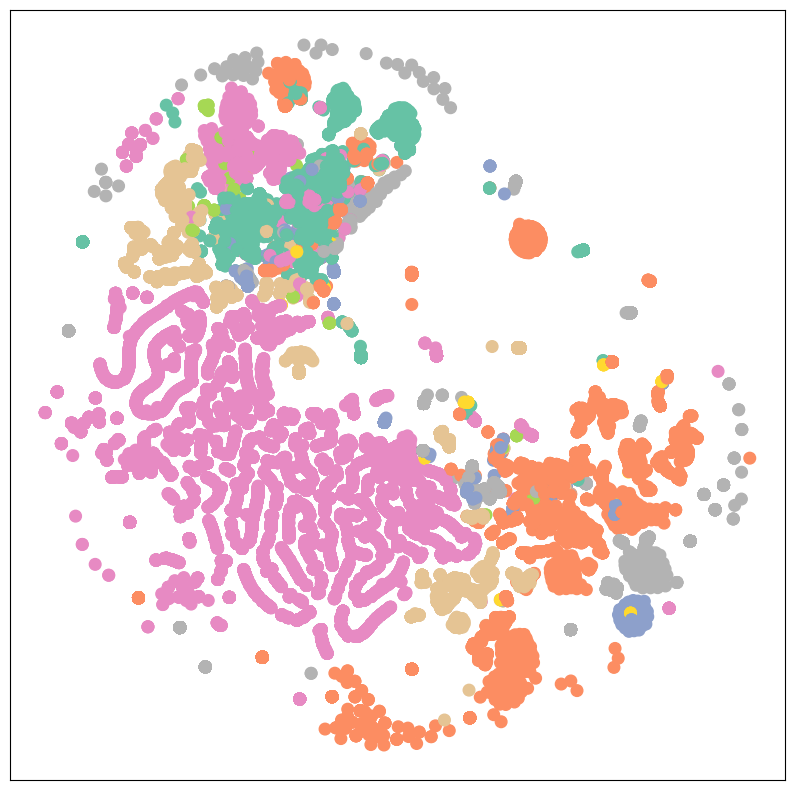

In [24]:
visualize(z,y)

<ipython-input-29-33f9d704249d>:19: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = plt.scatter(z[:, 0], z[:, 1], s=70, c=node_colors, cmap="tab20")


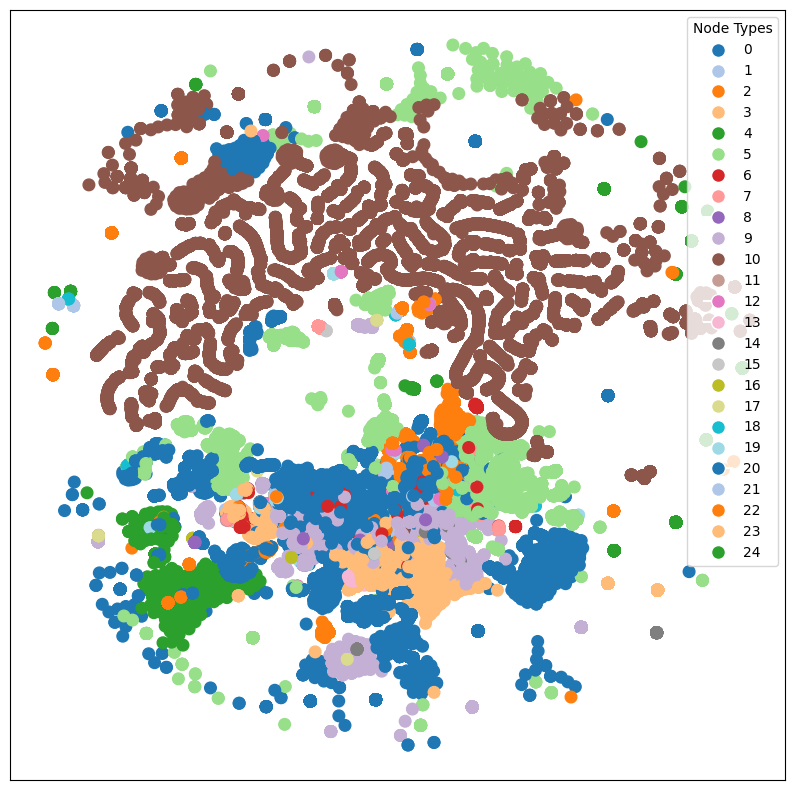

In [ ]:
visualize(z,y)

In [38]:
torch.save(model, view_path+'RGCNConv_model_view'+str(view)+'.pth')

In [26]:
import os

# Define the directory and file path
view =1
view_path = f'/content/drive/MyDrive/VIEW{view}/'
predictions_path = os.path.join(view_path, 'predictions')
file_path = os.path.join(predictions_path, f'view{view}_GNN_node_embeddings.csv')

# Ensure the directory exists
os.makedirs(predictions_path, exist_ok=True)

In [27]:
probs = edges_to_predict_filtered.copy()
probs['probability']=get_prob(external_test_data)
probs.to_csv(view_path+'predictions/view'+str(view)+'_GNN_node_embeddings.csv')

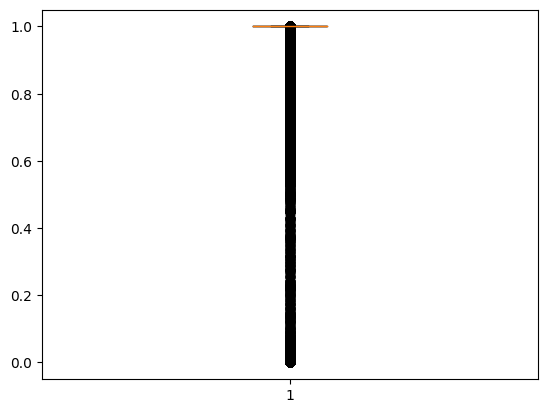

In [28]:
_=plt.boxplot(get_prob(test_data))

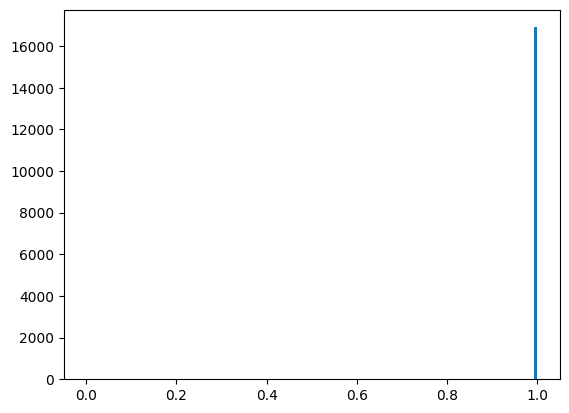

In [29]:
_=plt.hist(get_prob(external_test_data), bins=150, range=[0,1])

In [ ]:
nodes_df

,name,type
0,<http://purl.obolibrary.org/obo/MONDO_0007247>,Disease
1,<https://www.mirbase.org/mature/MIMAT0015042>,miRNA
2,<http://purl.obolibrary.org/obo/UBERON_0002195>,Anatomy
3,<http://purl.obolibrary.org/obo/MONDO_0004583>,Disease
4,<http://purl.obolibrary.org/obo/GO_0060761>,GO
...,...,...
85059,<http://purl.obolibrary.org/obo/MONDO_0010781>,Disease
85060,<http://purl.obolibrary.org/obo/HP_0100454>,Phenotype
85061,<http://www.ncbi.nlm.nih.gov/gene/57101>,Gene
85062,<http://www.ncbi.nlm.nih.gov/gene/51316>,Gene


In [30]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score

# Prepare the labels
true_labels = nodes_df['type']

In [31]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# Prepare the features and labels
X = z
y = true_labels

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train a classifier
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# Predict on the test set
y_pred = clf.predict(X_test)

In [32]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

# Calculate precision and recall
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

Accuracy: 0.9907
Precision: 0.9910
Recall: 0.9907


In [33]:
from grape import Graph
rna_kg_graph = Graph.from_pd(
    edges_df=edges_df,
    nodes_df=nodes_df,
    node_name_column="name",
    node_type_column="type",
    edge_src_column="subject",
    edge_dst_column="object",
    #edge_weight_column="weight",
    edge_type_column="type",
    node_types_separator="|",
    directed=False,
    name=view_name,
)

rna_kg_graph_directed = Graph.from_pd(
    edges_df=edges_df,
    nodes_df=nodes_df,
    node_name_column="name",
    node_type_column="type",
    edge_src_column="subject",
    edge_dst_column="object",
    #edge_weight_column="weight",
    edge_type_column="type",
    node_types_separator="|",
    directed=True,
    name=view_name+"_directed",
)

In [34]:
graph = rna_kg_graph_directed
# Function to simplify node names
def simplify_node_names(graph):
    simplified_node_names = [name[0] for name in graph.get_node_names()]
    return simplified_node_names

# Apply to the graph
simplified_node_names = simplify_node_names(graph)

In [35]:
from grape.edge_prediction import edge_prediction_evaluation
from grape.edge_prediction import DecisionTreeEdgePrediction, RandomForestEdgePrediction, ExtraTreesEdgePrediction, MLPEdgePrediction, GradientBoostingEdgePrediction,PerceptronEdgePrediction

evaluation = edge_prediction_evaluation(
    holdouts_kwargs=dict(train_size=0.8),
    graphs=graph,
    models=[RandomForestEdgePrediction()],
    number_of_holdouts=5,
    node_features=z,  # Use simplified embedding features
    smoke_test=True,
    enable_cache=False
)

Evaluating on VIEW1_directed:   0%|          | 0/5 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/331 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/83 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/331 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/83 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/331 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/83 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/331 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/83 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/331 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/83 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/331 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/83 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/331 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/83 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/331 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/83 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/331 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/83 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/331 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/83 [00:00<?, ?it/s]

In [36]:
results = pd.concat([results, evaluation], ignore_index = True)
filename = "results_"+view_name+"_FirstOrderLINEv1rg.csv"
results.to_csv(filename)

In [37]:
results

,evaluation_mode,train_size,validation_unbalance_rate,use_scale_free_distribution,accuracy,balanced_accuracy,false_omission_rate,informedness,matthews_correlation_coefficient,f1_score,...,"(model_parameters, max_features)","(model_parameters, max_leaf_nodes)","(model_parameters, min_impurity_decrease)","(model_parameters, bootstrap)","(model_parameters, oob_score)","(model_parameters, n_jobs)","(model_parameters, verbose)","(model_parameters, warm_start)","(model_parameters, ccp_alpha)","(model_parameters, max_samples)"
0,train,0.800001,1.0,True,0.480573,0.480573,0.544208,-0.038853,-0.046918,0.594287,...,sqrt,None,0.0,True,False,-1,False,False,0.0,None
1,test,0.800001,1.0,True,0.489668,0.489668,0.524469,-0.020665,-0.025317,0.604048,...,sqrt,None,0.0,True,False,-1,False,False,0.0,None
2,train,0.800001,1.0,True,0.480578,0.480578,0.544208,-0.038843,-0.046910,0.594309,...,sqrt,None,0.0,True,False,-1,False,False,0.0,None
3,test,0.800001,1.0,True,0.488807,0.488807,0.526585,-0.022387,-0.027456,0.603565,...,sqrt,None,0.0,True,False,-1,False,False,0.0,None
4,train,0.800001,1.0,True,0.480351,0.480351,0.544735,-0.039297,-0.047462,0.594147,...,sqrt,None,0.0,True,False,-1,False,False,0.0,None
5,test,0.800001,1.0,True,0.489653,0.489653,0.524559,-0.020694,-0.025375,0.604182,...,sqrt,None,0.0,True,False,-1,False,False,0.0,None
6,train,0.800001,1.0,True,0.480636,0.480636,0.544091,-0.038728,-0.046776,0.594376,...,sqrt,None,0.0,True,False,-1,False,False,0.0,None
7,test,0.800001,1.0,True,0.488844,0.488844,0.526429,-0.022313,-0.027340,0.603427,...,sqrt,None,0.0,True,False,-1,False,False,0.0,None
8,train,0.800001,1.0,True,0.480767,0.480767,0.543790,-0.038465,-0.046458,0.594476,...,sqrt,None,0.0,True,False,-1,False,False,0.0,None
9,test,0.800001,1.0,True,0.488644,0.488644,0.526865,-0.022712,-0.027815,0.603182,...,sqrt,None,0.0,True,False,-1,False,False,0.0,None
